In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os

In [3]:
current = np.arange(0,7.04,0.02)
field = 1.61893 + 26.1952 * current # length of field is number of files

directory = os.path.join("HRRPY180","HRRYIG_BJ_PY")

In [4]:
def read_s_params(directory):
    

    files = [f for f in os.listdir(directory) if f.endswith('.csv')]

    s_parameters = dict()

    freqs = pd.read_csv(os.path.join(directory, files[0]), header=0, index_col=0).index.to_numpy()

    for file in files:
        data = pd.read_csv(os.path.join(directory, file), header=0, index_col=0)
        for key in data.keys():
            if key not in s_parameters:
                s_parameters[key] = np.empty((len(files), len(data)))
            s_parameters[key][files.index(file), :] = data[key].to_numpy()
    

    return s_parameters, freqs

In [10]:
def normalise(data_array):
    """Normalise the data_array by subtracting the higher order modes."""
    row0 = data_array[0, :]
    row0_abs = np.abs(row0)
    # min_idx = np.argmin((row0_abs[1:-1] < row0_abs[:-2]) & (row0_abs[1:-1] < row0_abs[2:])) + 1
    min_idx = np.argmin(row0_abs[:row0_abs.size//2])  # Find the minimum in the first half
    row0[:min_idx] = 0
    plt.plot(row0_abs)
    plt.plot(min_idx,row0_abs[min_idx],'ro')
    plt.show()
    return data_array - row0

In [11]:
def s_param_plot(directory=directory, norm=False, log=False):

    cmap = "inferno" if not log else "inferno_r"

    s_parameters, freqs = read_s_params(directory)

    fig, axs = plt.subplots(2,2, figsize=(10, 10),sharey=True)
    keys = ['S11', 'S21', 'S12', 'S22']
    for i, ax in enumerate(axs.flat):
        plot_data = s_parameters[f'{keys[i]}_Real']+1j*s_parameters[f'{keys[i]}_Imaginary']
        if norm:
            # plot_data -= plot_data[0,:]  # Subtract the first row for normalization
            if log:
                plot_data = np.log(np.abs(plot_data).T)
            else:
                plot_data = np.abs(plot_data).T
            plot_data = normalise(plot_data)
        else:
            if log:
                plot_data = np.log(np.abs(plot_data).T)
            else:
                plot_data = np.abs(plot_data).T
        ax.pcolormesh(field,freqs*1e-9,plot_data,cmap=cmap)
        if i % 2 == 0:
            ax.set_ylabel("Freq (GHz)")
        ax.set_xlabel("Field (mT)")
        ax.set_title(f"{keys[i]} Magnitude")
        ax.set_ylim(2.5,7.5)
    fig.suptitle(directory+norm*" Normalised"+log*" log", fontsize=16)
    plt.tight_layout()
    # plt.colorbar(axs[-1])
    if not norm:
        plt.savefig(directory + "_raw")
    else:
        filename = directory + "_normalised"
        plt.savefig(filename)
    plt.show()

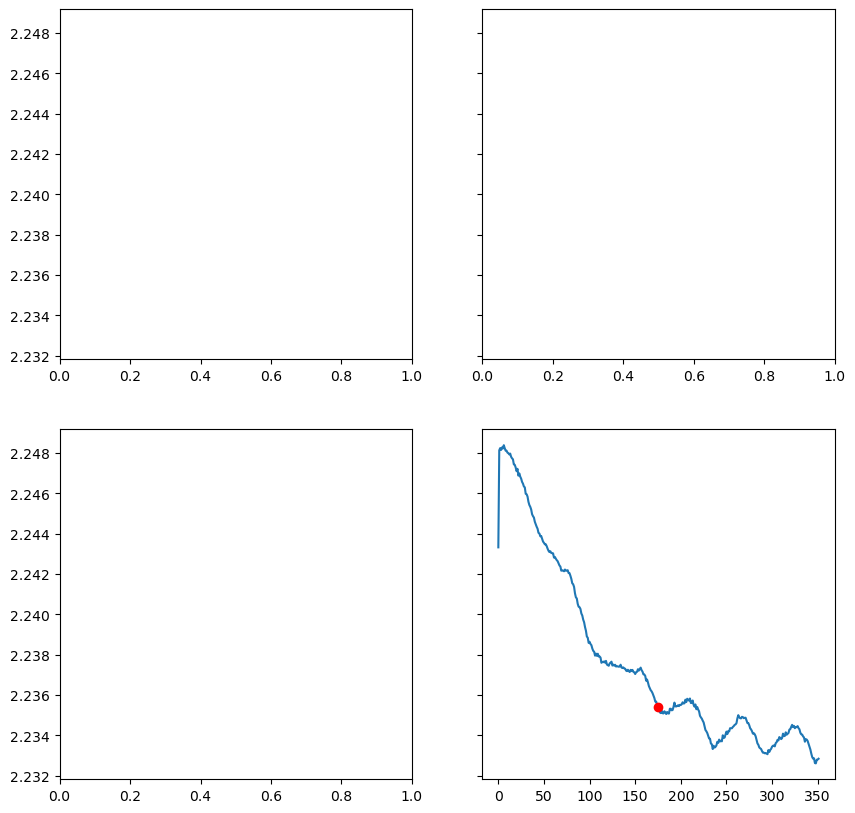

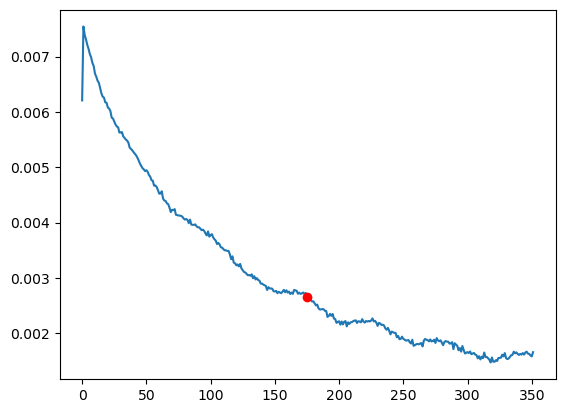

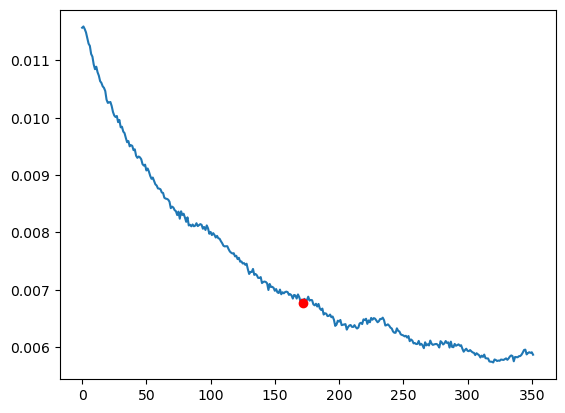

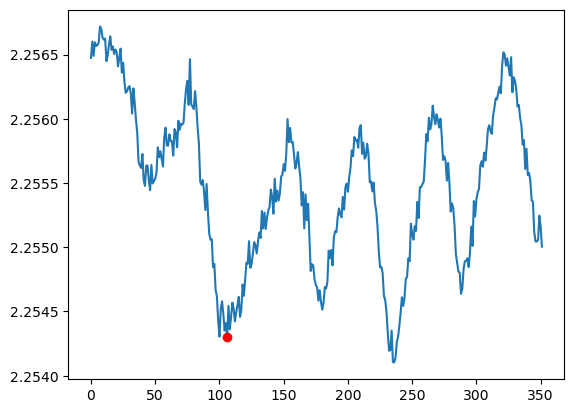

<Figure size 640x480 with 0 Axes>

In [12]:
# s_param_plot()
s_param_plot(norm=True,log=True)

In [13]:
assert 0

dirs = os.listdir(".")
for d in dirs:
    if os.path.isdir(d) and d.startswith("HRR"):
        # Check if there are any directories inside d
        subdirs = [name for name in os.listdir(d) if os.path.isdir(os.path.join(d, name))]
        for sd in subdirs:
            directory = os.path.join(d, sd)
            print(f"Processing directory: {directory}")
            s_param_plot(directory, norm=True)
            s_param_plot(directory) 

AssertionError: 

In [ ]:
data = read_s_params(directory)[0]
# data['S21_Real']+1j*data['S21_Imaginary']
np.savez("s_params_BJ.npz", **data, allow_pickle=False)

In [ ]:
s21 = data['S21_Real'] + 1j * data['S21_Imaginary']

pd.DataFrame(s21, index=field).to_csv("s21.csv")